In [2]:
import numpy as np

### Load the data

In [3]:
data = np.genfromtxt("habib_bank_21.csv", delimiter=',', dtype=str, skip_header=1)
print(data.shape)

(1047, 7)


### Categorize the data

In [4]:
dates = data[:, 0]
prices_str = data[:, 1]
opens_str = data[:, 2]
highs_str = data[:, 3]
lows_str = data[:, 4]
volumes_str = data[:, 5]
changes_str = data[:, 6]

In [5]:
prices = np.array([float(price.strip("\"")) for price in prices_str])
opens_ = np.array([float(o.strip("\"")) for o in opens_str])
highs = np.array([float(high.strip("\"")) for high in highs_str])
lows = np.array([float(low.strip("\"")) for low in lows_str])

### Convert String to Numbers

In [6]:

# Volume: Convert K/M to actual numbers
def parse_volume(vol_str):
    vol_str = vol_str.split("\"")[1]
    if vol_str.endswith('M'):
        return float(vol_str[:-1]) * 1e6
    elif vol_str.endswith('K'):
        return float(vol_str[:-1]) * 1e3
    else:
        return float(vol_str)

volume = np.array([parse_volume(v) for v in volumes_str])

# Change %: Remove '%' and convert to float
change_percent = np.array([float(x.split("\"")[1].strip('%')) for x in changes_str])




### Normalizing
Standardize the data using max and min values 

In [7]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

norm_price = normalize(prices)
norm_open = normalize(opens_)
norm_high = normalize(highs)
norm_low = normalize(lows)
norm_volume = normalize(volume)
norm_change = normalize(change_percent)


### Plotting graphs

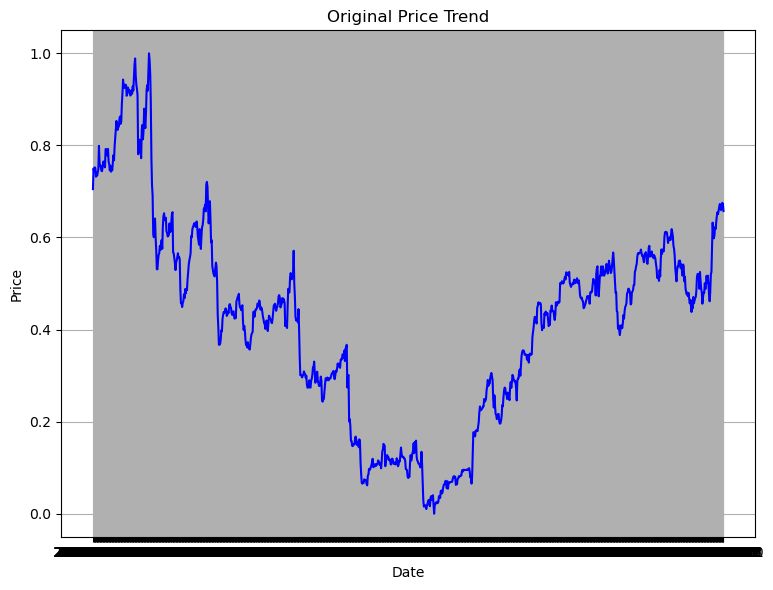

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

cleaned_dates = [d.strip().replace('"', '') for d in dates]
reformatted_dates = [f"{d.split('/')[2]}-{d.split('/')[0]}-{d.split('/')[1]}" for d in cleaned_dates]
# Normalize function
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


# Plot
plt.figure(figsize=(15, 6))

# Original
plt.subplot(1, 2, 1)
plt.plot(reformatted_dates, norm_price, label='Original Price', color='blue')
plt.title("Original Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)

plt.tight_layout()
plt.show()


/tmp/ipykernel_39937/2979085242.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([opens_, highs, lows, prices, volume],


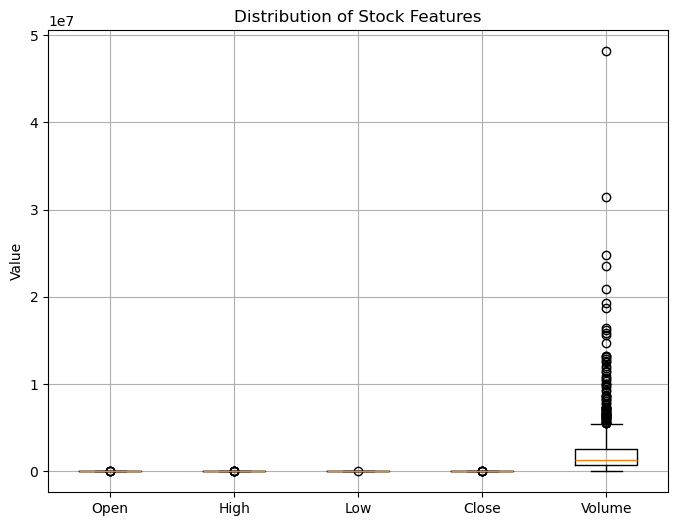

In [70]:
plt.figure(figsize=(8, 6))
plt.boxplot([opens_, highs, lows, prices, volume],
            labels=['Open', 'High', 'Low', 'Close', 'Volume'])
plt.title("Distribution of Stock Features")
plt.ylabel("Value")
plt.grid(True)
plt.show()


### Concatenating the data

In [18]:
# Stack all normalized features horizontally
features = np.column_stack([
    norm_price, norm_open, norm_high, 
    norm_low, norm_volume, norm_change
])  # Shape: (num_days, 6)

In [11]:
assert features.shape[1] == 6, "Features should have 6 columns"

In [13]:
features[0]

array([0.70503247, 0.75212141, 0.74436029, 0.70590717, 0.1936307 ,
       0.17847534])

### Creating sequences using lookback of 60 days

In [ ]:
def create_sequences(data, targets, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])  
        y.append(targets[i+lookback])  
    return np.array(X), np.array(y)


In [19]:
from config import LOOKBACK_WINDOW
targets = prices[1:]  # Predict next day's raw price
X, y = create_sequences(features[:-1], targets, LOOKBACK_WINDOW)

assert X.shape[2] == 6, "X should have 6 features"
assert X.shape[0] == y.shape[0], "Both should have same number of samples"

In [17]:
print(X.shape)
print(y.shape)

(986, 60, 6)
(986,)


### Splitting

In [21]:
from config import TEST_SPLIT, VAL_SPLIT
num_samples = len(X)
train_end = int(num_samples * (1 - TEST_SPLIT - VAL_SPLIT))
val_end = train_end + int(num_samples * VAL_SPLIT)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

assert X_train.shape[0] == y_train.shape[0], "Trained data dimensions do not match"
assert X_val.shape[0] == y_val.shape[0], "Validation data dimensions do not match"
assert X_test.shape[0] == y_test.shape[0], "Test data dimensions do not match"

In [23]:
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (690, 60, 6), Val: (147, 60, 6), Test: (149, 60, 6)


### Saving the preprocessed data to numpy format


In [24]:
np.savez('data/processed_21.npz',
         X_train=X_train, y_train=y_train,
         X_val=X_val, y_val=y_val,
         X_test=X_test, y_test=y_test)

### Testing LSTMCell Class

In [26]:
from lstm import LSTMCell

input_size = 6  # Features (price, open, high, low, volume, change)  
hidden_size = 64  

lstm_cell = LSTMCell(input_size, hidden_size)  

# Random input (single timestep)  
x = np.random.randn(input_size)  
h_prev = np.zeros(hidden_size)  
c_prev = np.zeros(hidden_size)  

h_next, c_next = lstm_cell.forward_step(x, h_prev, c_prev)  
print("h_next shape:", h_next.shape)  # Should be (hidden_size,)  

h_next shape: (64, 64)
